# pyWATTS Übung 2023

## Agenda 

Data Analysis

    - Description of the Dataset
    - Data Visualisation
    - Overview Weekday vs Weekend ?
    - Seasonal Decomposition

Forecasting with PyWatts

    - Maybe show Normalisation ?
    - Maybe show Calendar Features?
    - 




## Chat GPT - What is Pywatts?
### Chat GPT's Opinion

>“Pywatts is an open-source Python library designed to simplify time series analysis. It provides users with a range of powerful tools for exploring, visualizing, and modeling time series data. Pywatts is particularly useful for tasks such as forecasting, anomaly detection, and data preprocessing. The library includes a wide range of functionality, including a suite of built-in data loaders for importing time series data from a variety of sources, such as CSV files, databases, and web APIs. Pywatts also includes a range of data preprocessing tools, such as resampling, interpolation, and feature engineering, that can help users to prepare their time series data for analysis. One of the key features of Pywatts is its support for a range of machine learning models for time series analysis. These models include popular algorithms such as ARIMA, LSTM, and GRU models, as well as models for anomaly detection, such as isolation forests and one-class SVMs. Pywatts also provides tools for model training, evaluation, and deployment, making it an ideal platform for both research and production environments. Pywatts is designed to be easy to use, with a simple and intuitive interface that makes it accessible to users with a wide range of backgrounds and skill levels. The library is actively maintained and supported by a community of developers, ensuring that it is up-to-date and compatible with the latest versions of Python and other libraries. Overall, Pywatts is a powerful and flexible tool for anyone working with time series data. Whether you are a researcher, analyst, or data scientist, Pywatts can help you to quickly and easily preprocess, analyze, and model your time series data, enabling you to gain valuable insights and make informed decisions.“

### What is right what is wrong ? 




## Data Loading

In [111]:
import pandas as pd
import statsmodels.api as sm
import pylab
pylab.rcParams['figure.figsize'] = (14, 9)

In [112]:
date_parser = lambda date: pd.Timestamp(pd.to_datetime(date, format= '%Y-%m-%dT%H:%M:%SZ'))
data_res = pd.read_csv("data/household_data_15min_singleindex_filtered-2.csv", index_col="utc_timestamp", parse_dates=True ,date_parser=date_parser, sep=',')


data_res["demand"] = data_res["DE_KN_industrial3_grid_import"].diff(1)
data_res["solar"] = data_res["DE_KN_industrial3_pv_roof"].diff(1)

data_building = data_res[["demand","solar"]].dropna()
#data_building.index = pd.to_datetime(data_building.index,utc=True)




<Axes: xlabel='utc_timestamp'>

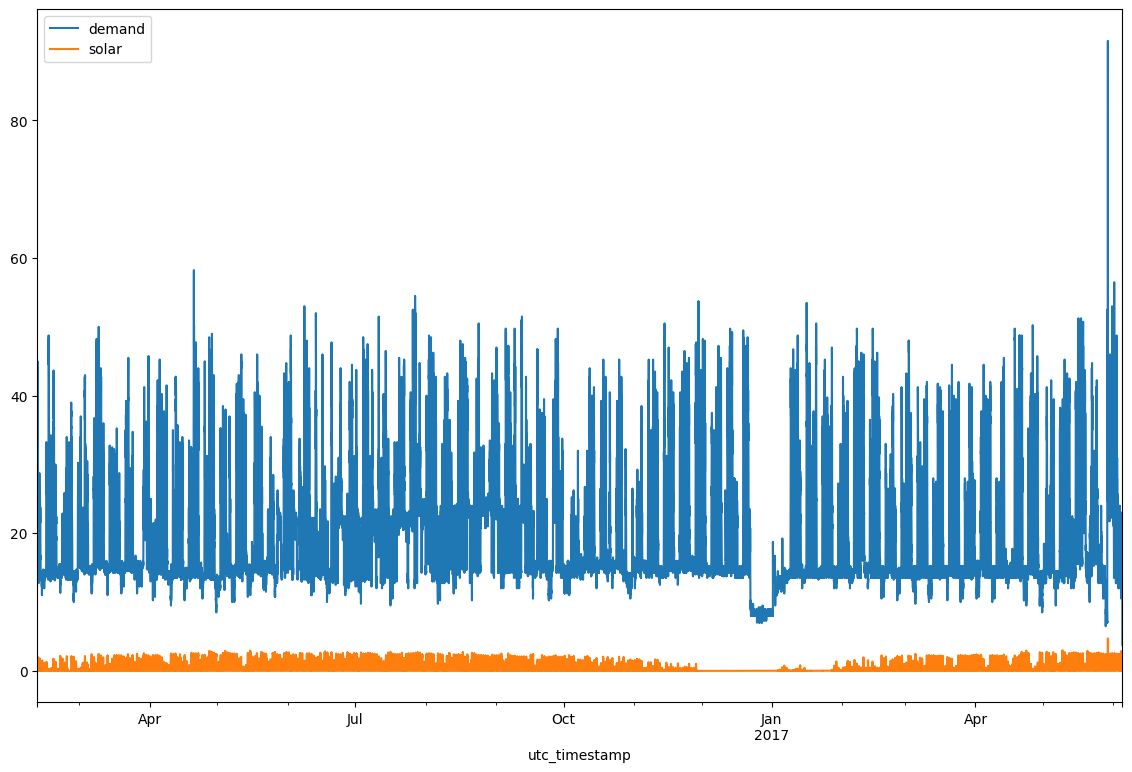

In [113]:
#date_parser = lambda date: pd.Timestamp(pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S'))
#data = pd.read_csv("data/data_building_109_ausgrid.csv", index_col="time", parse_dates = ["time"], date_parser=date_parser)
#data.head()

data= data_building
data.plot()

## Data Analysis

In [114]:
data.describe()

,demand,solar
count,46035.000000,46035.000000
mean,19.902008,0.403097
std,8.249474,0.686114
min,3.750000,0.000000
25%,14.250000,0.000000
50%,15.500000,0.000000
75%,24.000000,0.502279
max,91.568181,4.725142


In [115]:
data[["demand","solar"]].head()

data =  data[data.index > pd.to_datetime("2016-11-03")]
#data.plot()

### Compare Workingdays and Weekends

#### Workingdays

/var/folders/hy/fx6x4r6s61n7nm9q79g5vbmr3svmvm/T/ipykernel_36718/1357770307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["minute_of_the_day"] = data.index.hour * 60 + data.index.minute
/var/folders/hy/fx6x4r6s61n7nm9q79g5vbmr3svmvm/T/ipykernel_36718/1357770307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["days_since_start"] = [int(x/(96)) for x in range(0,len(data))]
/var/folders/hy/fx6x4r6s61n7nm9q79g5vbmr3svmvm/T/ipykernel_36718/1357770307.py:4: SettingWithCopyWarning: 
A value is 

<Axes: xlabel='minute_of_the_day'>

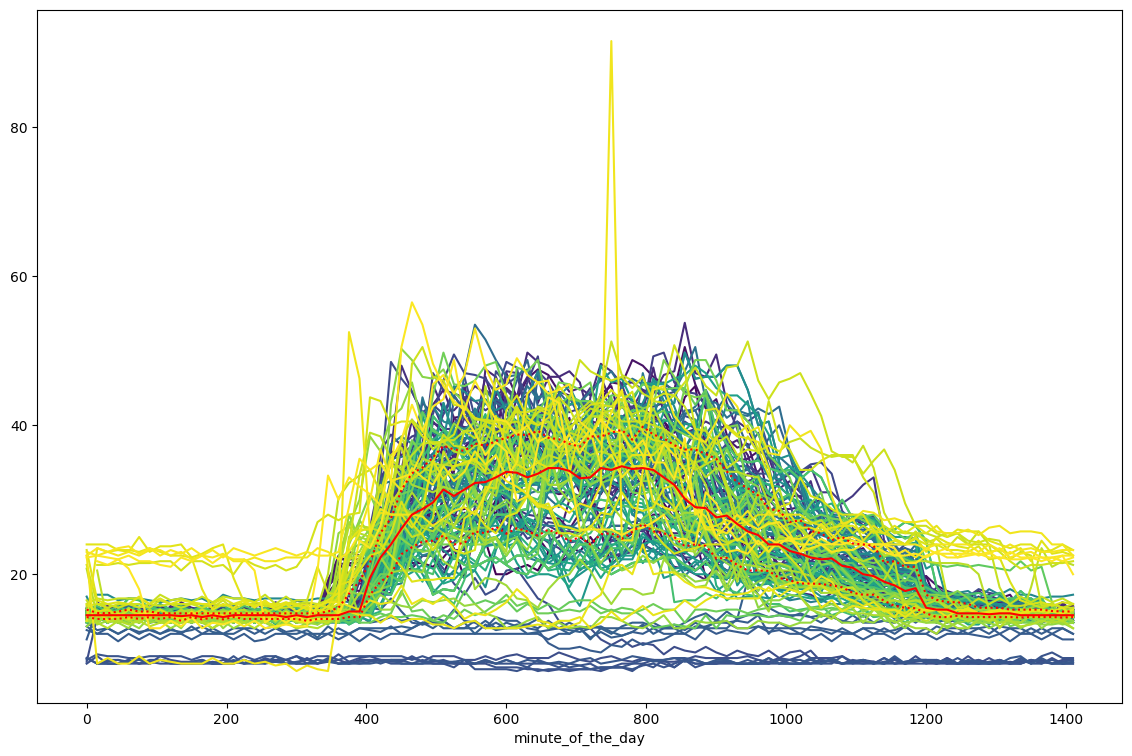

In [116]:
#plots the first two weeks
data["minute_of_the_day"] = data.index.hour * 60 + data.index.minute
data["days_since_start"] = [int(x/(96)) for x in range(0,len(data))]
data['weekday'] = data.index.weekday

pivot = pd.pivot_table(data[data["weekday"] < 5], index=['minute_of_the_day'],columns=['days_since_start'], values=['demand'])[:-1]
pivot["demand"].plot(legend=False,colormap="viridis")
pivot.median(axis=1).plot(color="red")
pivot.quantile(0.25,axis=1).plot(color="red",linestyle='dotted')
pivot.quantile(0.75,axis=1).plot(color="red",linestyle='dotted')


#### Weekend

<Axes: xlabel='minute_of_the_day'>

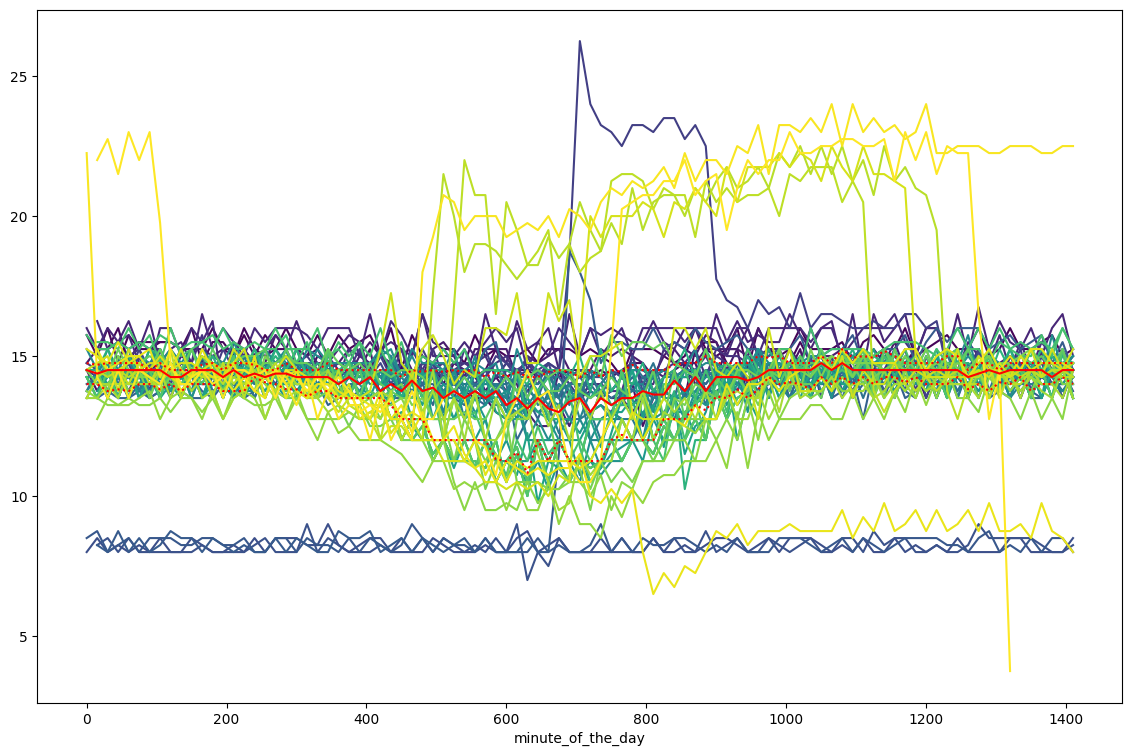

In [117]:

pivot = pd.pivot_table(data[data["weekday"] >= 5], index=['minute_of_the_day'],columns=['days_since_start'], values=['demand'])[:-1]
pivot["demand"].plot(legend=False,colormap="viridis")
pivot.median(axis=1).plot(color="red")
pivot.quantile(0.25,axis=1).plot(color="red",linestyle='dotted')
pivot.quantile(0.75,axis=1).plot(color="red",linestyle='dotted')

### Seasonal Decomposition

Can be found here: 
https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

The additive model is $Y[t] = T[t] + S[t] + e[t]$

The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

#### Visualisation Demand

##### Key Obervations :

- Weekly Pattern visible through the seasonal component Plot 168
- Daily Pattern visble through the seasonal component Plot 24


#### Demand - a weekly pattern

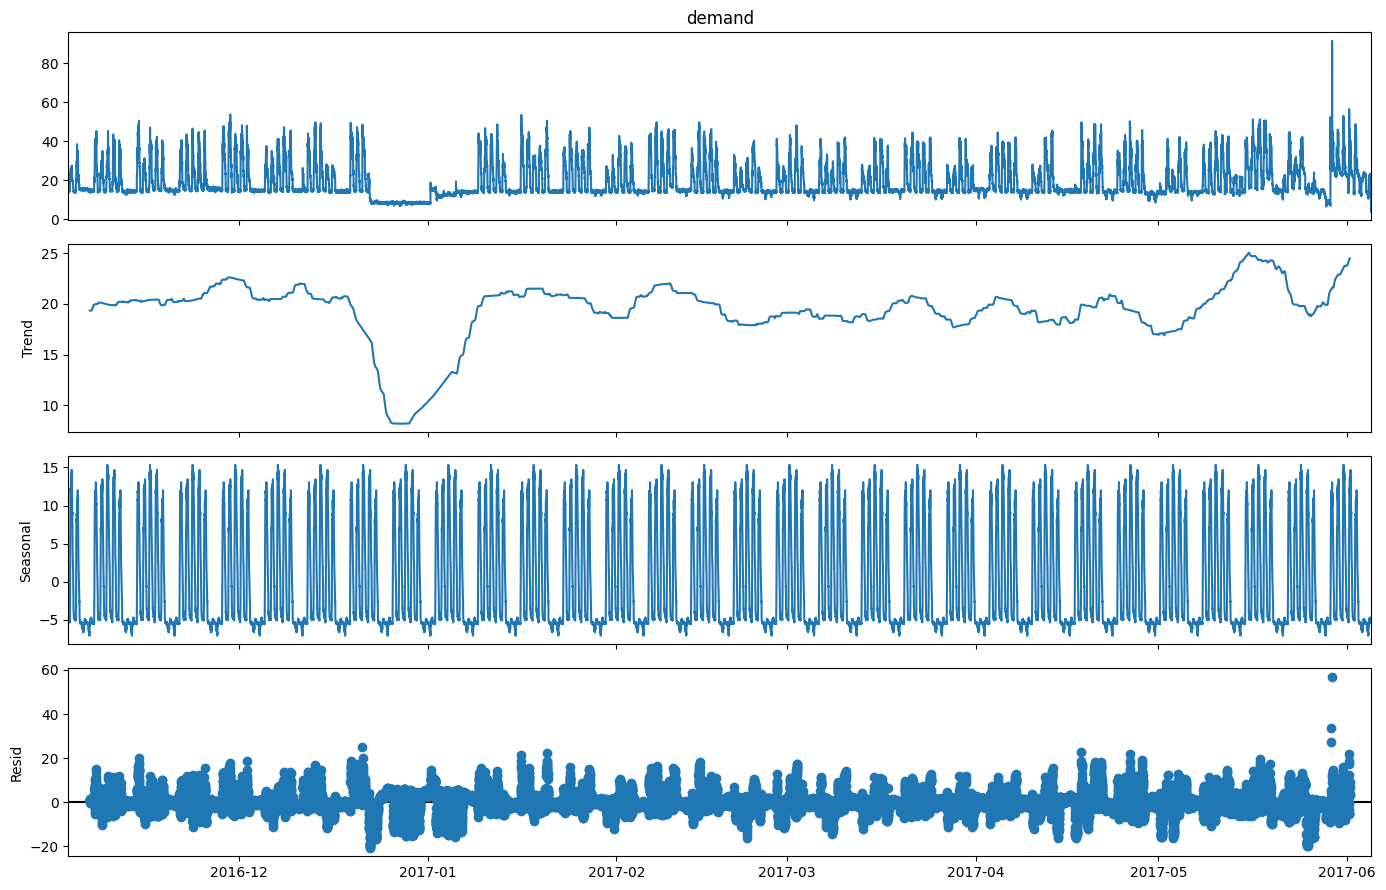

In [118]:
res = sm.tsa.seasonal_decompose(data["demand"][:], period= 24*4*7)
resplot = res.plot()

#### Demand - a dailiy pattern

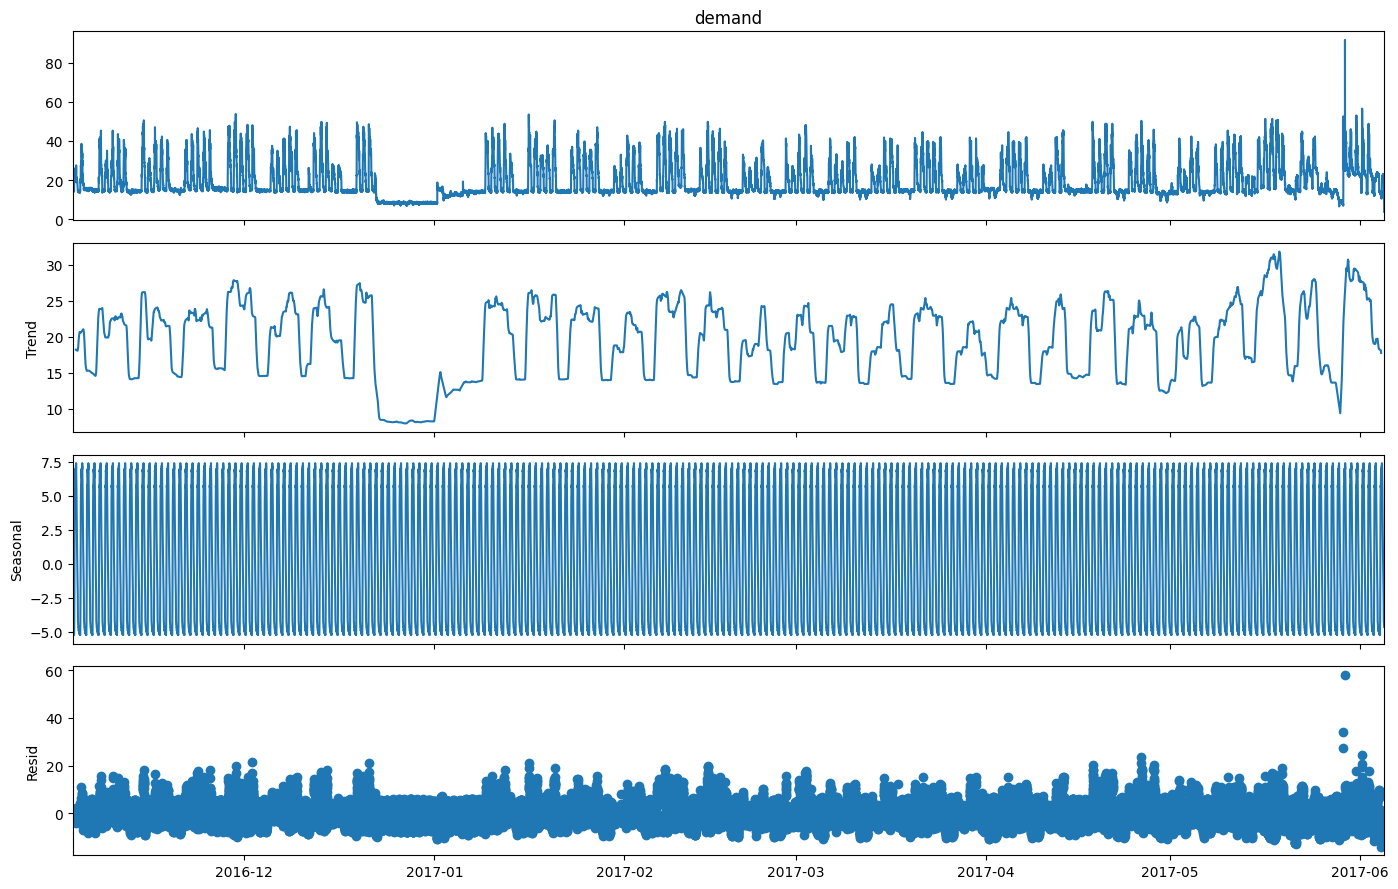

In [119]:
res = sm.tsa.seasonal_decompose(data["demand"][:], period=24*4)
resplot = res.plot()

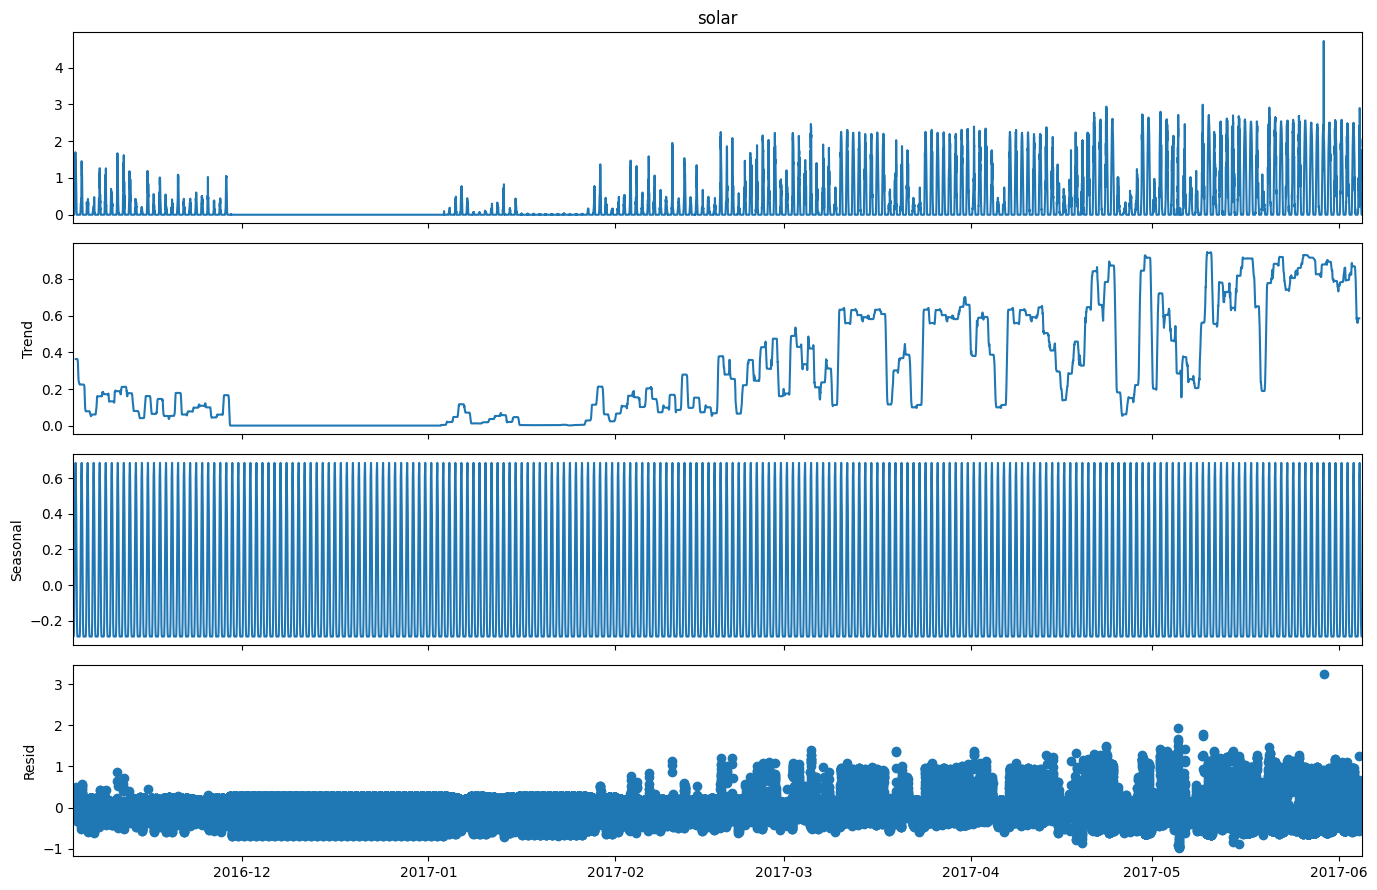

In [120]:
res = sm.tsa.seasonal_decompose(data["solar"][:], period=24*4)
resplot = res.plot()

## Forecasting with pyWatts

In this section of the Jupyter Notebook, you will learn about using pyWatts to perform time series forecasting. Time series forecasting is a technique used to predict future values of a variable based on historical data. It can be useful in many fields, such as finance, economics, and engineering.

The section walks you through the creation of a pipeline for time series forecasting. The pipeline includes several steps, such as data preprocessing, model selection, and evaluation. By following the steps in the pipeline, you will learn how to create a 24-hour ahead forecast, which is the prediction of the value of a variable 24 hours into the future based on historical data. Visible in this figure:

<img src="images/24_hours_ahead_forecast_2.png" width="800" height="300">

To evaluate the accuracy of the forecast, the section provides various metrics, such as mean absolute error and root mean squared error. These metrics allow you to understand how close the forecasted values are to the actual values. Those Metrics are introduced here:


MAE = $\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})$


RMSE = $\sqrt{\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2}$


To help with the interpretation of the results, the section includes visualizations of the forecasted values and actual values over time. These visualizations can help you identify trends and patterns that may not be immediately apparent from the metrics alone.

Overall, this section provides a practical introduction to using pyWatts for time series forecasting. By the end of the section, you will have a good understanding of the pipeline for time series forecasting and how to evaluate the accuracy of your forecasts.

In [121]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.util.computation_mode import ComputationMode

from pywatts.modules import SKLearnWrapper
from pywatts.modules.preprocessing.select import Select
from pywatts.modules.wrappers import FunctionModule
from pywatts.modules.feature_extraction.calendar_extraction import CalendarExtraction, CalendarFeature
from pywatts.summaries import RMSE, MAE

def get_forecasting_pipeline(forecast_horizon, historical_features,scope_var,sklearn_wrappers):


    forecast_pipeline = Pipeline(f"results/")


    calendar = CalendarExtraction('calendar',continent="Europe", country="Germany",
                                           features=[CalendarFeature.month_sine, CalendarFeature.month_cos,
                                                    CalendarFeature.weekday_sine, CalendarFeature.weekday_cos,
                                                    CalendarFeature.workday, CalendarFeature.holiday])(x=forecast_pipeline[scope_var])

    data_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler")
    data_scaled = data_scaler(x=forecast_pipeline[scope_var])

    input = Select(start=-historical_features, stop=0, step=1, name="Sample_historical_features")(x=data_scaled)
    target_scaled = Select(start=0, stop=forecast_horizon, step=1, name="Sample_targets")(x=data_scaled)
    calendar_selected = Select(start=0, stop=forecast_horizon, step=1, name="Sample_targets")(x=calendar)
    

    result_dict= {}
    result_dict_unscaled = {}
    target = data_scaler(x=target_scaled, computation_mode=ComputationMode.Transform, method="inverse_transform")
    FunctionModule(lambda x:x, name='target')(x=target)
    
    for forecaster in sklearn_wrappers:
        result_dict[forecaster.name] = forecaster(
        features=input,
        calendar=calendar_selected,
        target=target_scaled,
        )

        result_dict_unscaled[forecaster.name] = data_scaler(x=result_dict[forecaster.name], computation_mode=ComputationMode.Transform,method="inverse_transform")
        FunctionModule(lambda x:x, name='forecast_' + forecaster.name)(x=result_dict_unscaled[forecaster.name])
        

        rmse = RMSE(name="rmse_" + forecaster.name)(y_hat=result_dict_unscaled[forecaster.name] , y=target)
        mae = MAE(name="mae_" + forecaster.name)(y_hat=result_dict_unscaled[forecaster.name] , y=target)



    




    return forecast_pipeline



/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-packages/pywatts_pipeline/core/transformer/base.py:195: UserWarning: The step with name Sample_targets is renamed to Sample_targets_1 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-packages/pywatts_pipeline/core/transformer/base.py:195: UserWarning: The step with name scaler is renamed to scaler_1 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-packages/pywatts_pipeline/core/transformer/base.py:195: UserWarning: The step with name scaler is renamed to scaler_2 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/

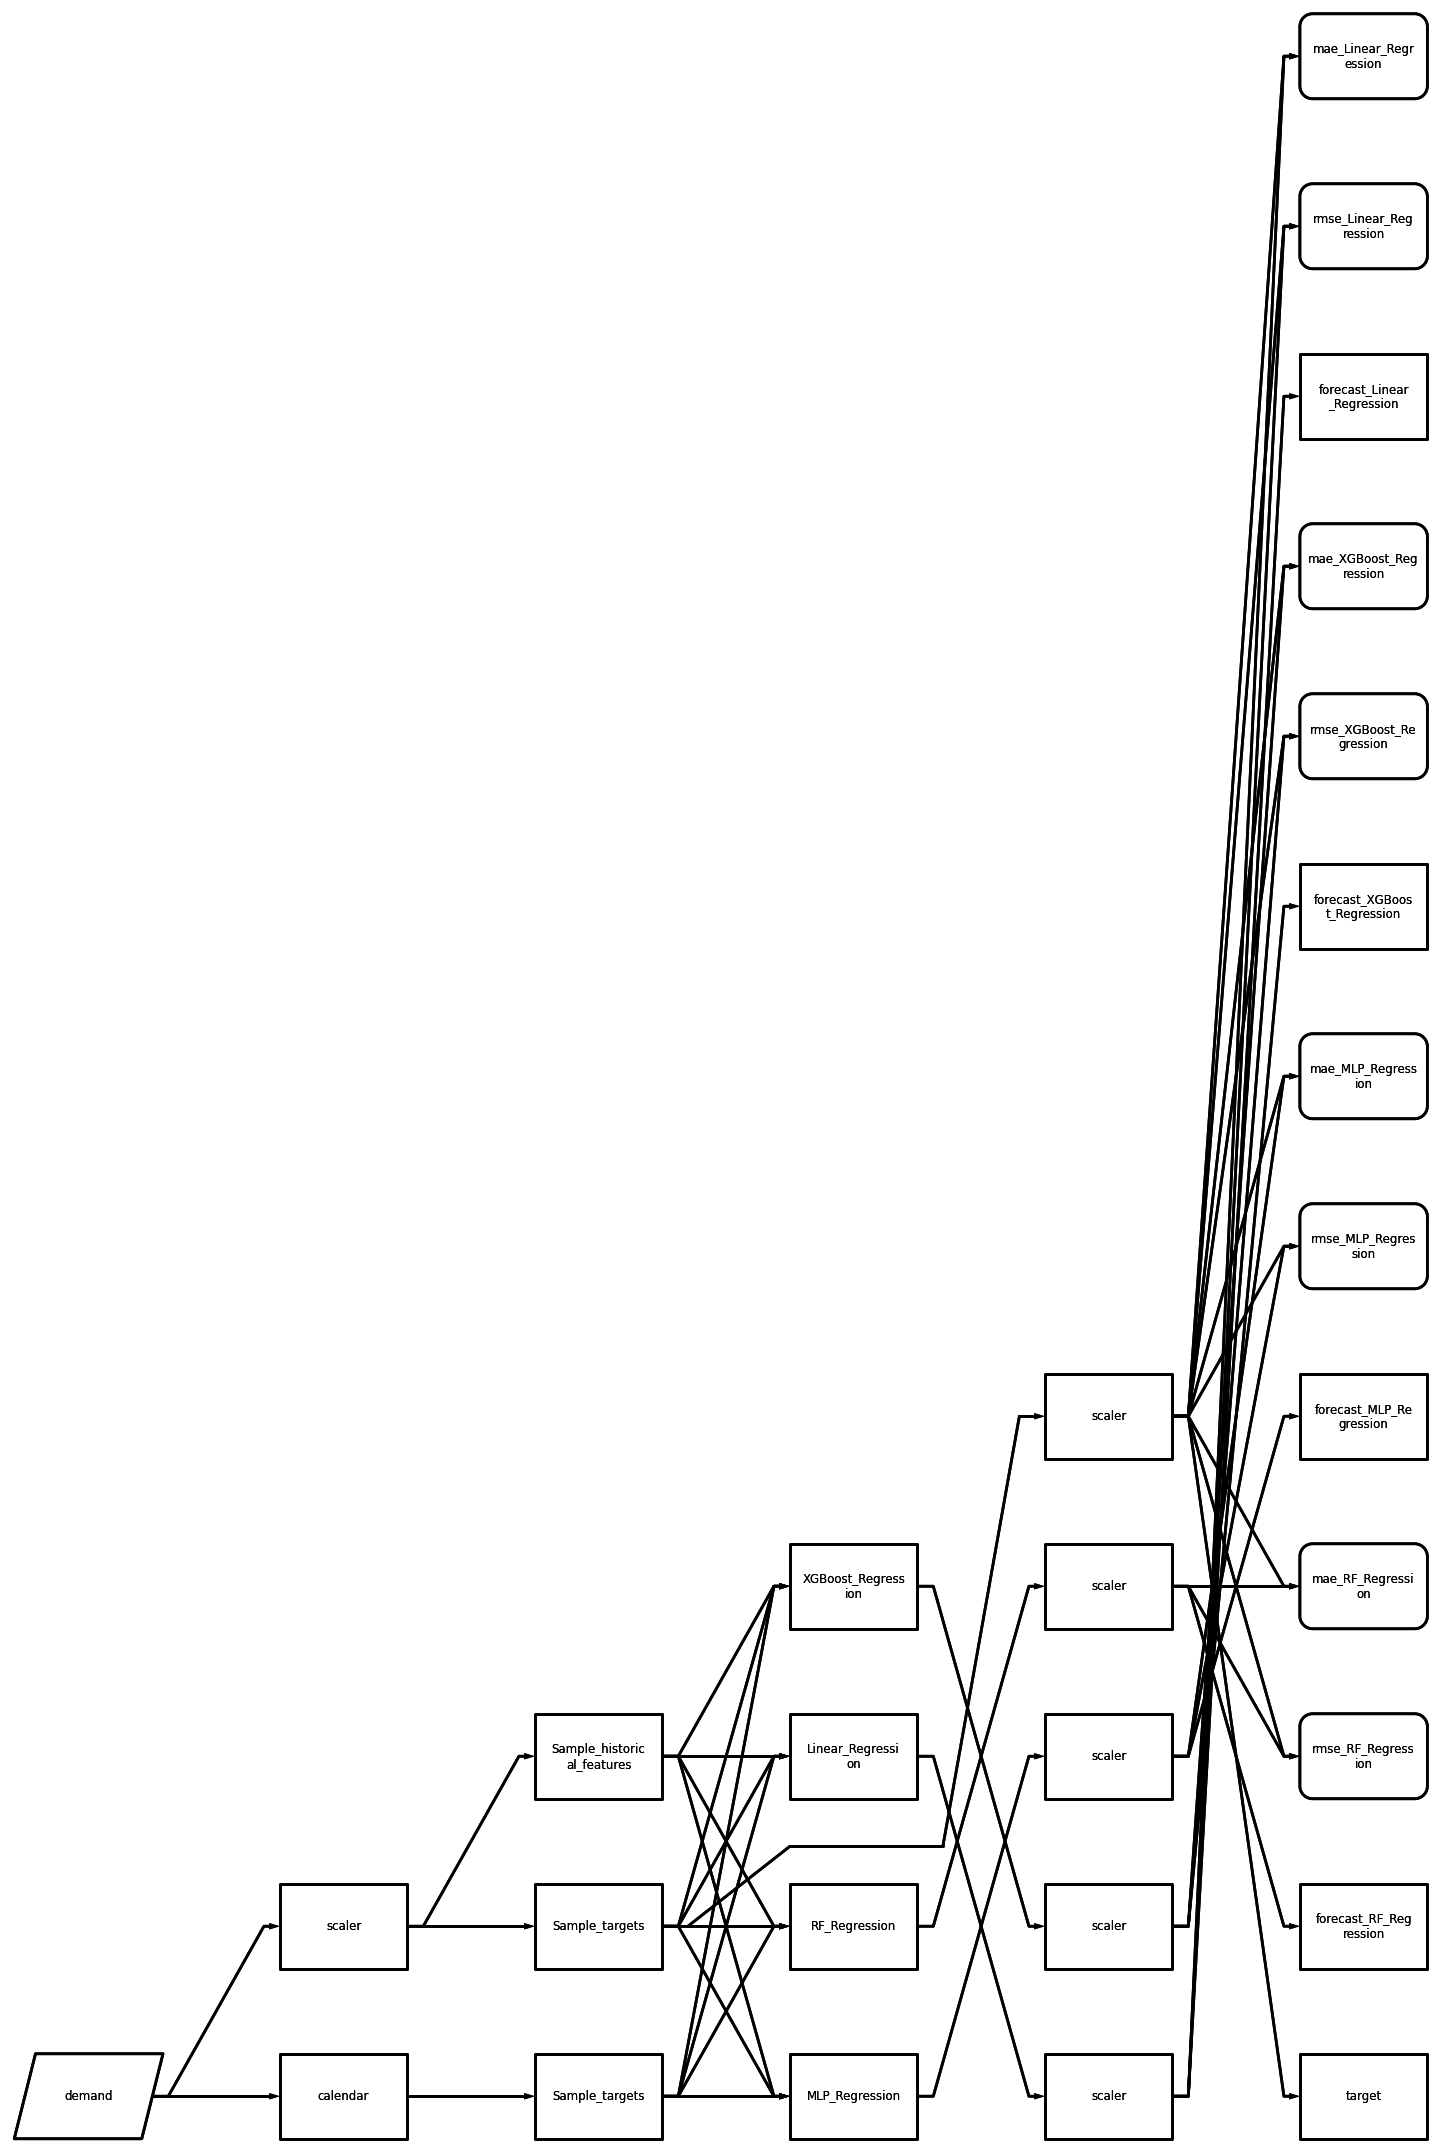

In [122]:
SCOPE_VARIABLE =  ["demand"]
TRAINING_END = pd.Timestamp("2017-03-01")


forecasters = [ SKLearnWrapper(module=RandomForestRegressor(), name="RF_Regression"),
                SKLearnWrapper(module=MLPRegressor(hidden_layer_sizes=(64,32,16), max_iter=1000),name="MLP_Regression"),
                SKLearnWrapper(module=XGBRegressor(), name="XGBoost_Regression"),
                SKLearnWrapper(module=LinearRegression(), name="Linear_Regression")
                ]

training_data = data[SCOPE_VARIABLE][:TRAINING_END]
testing_data = data[SCOPE_VARIABLE][TRAINING_END:]

pipeline = get_forecasting_pipeline(24,24,"demand",forecasters)


res_train , summary_train  = pipeline.train(training_data)

res_test , summary_test  = pipeline.test(testing_data)


drawing = pipeline.draw()
drawing.draw()








# Result Visualisation

The basic functionality to acess the metrics in pyWATTS is called Summary. They get saved in the result files. 

In [123]:
print(summary_test)

# Summary: 
## Summary
### rmse_RF_Regression

* y_hat : 5.162497848073101
### mae_RF_Regression

* y_hat : 3.070528629065482
### rmse_MLP_Regression

* y_hat : 6.844667138633324
### mae_MLP_Regression

* y_hat : 4.606073503766618
### rmse_XGBoost_Regression

* y_hat : 5.609714533086845
### mae_XGBoost_Regression

* y_hat : 3.4840363286770386
### rmse_Linear_Regression

* y_hat : 6.940290706725437
### mae_Linear_Regression

* y_hat : 5.405763222672637
## FitTime
### calendar Training Time

*  : 1.1920928955078125e-06
### scaler Training Time

*  : 0.00025391578674316406
### Sample_historical_features Training Time

*  : 7.152557373046875e-07
### Sample_targets Training Time

*  : 1.1920928955078125e-06
### Sample_targets Training Time

*  : 9.5367431640625e-07
### target Training Time

*  : 9.5367431640625e-07
### RF_Regression Training Time

*  : 23.613185167312622
### forecast_RF_Regression Training Time

*  : 1.9073486328125e-06
### MLP_Regression Training Time

*  : 20.814002990722

In [124]:
# Todo Some fancy Plots 





# Plot Prediction vs Reality in different Models


# Plot Maybe public holiday 
